In [1]:
import uproot
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
parent = os.path.dirname(os.path.abspath(''))
if not parent in sys.path:
    sys.path.append(parent)
from ana_tools import manual_std

import dunestyle.matplotlib as dunestyle


DUNE plot style enabled


In [7]:
def load_data(fname):
    with uproot.open(fname) as f:
        data = f['analysistree/atmoOutput'].arrays(library='pd')
    return pl.from_pandas(data)

beam_data = load_data('/pnfs/dune/persistent/users/pgranger/atmospherics-data/beam_forcomparison_atmoana.root')
atm_data = load_data('/pnfs/dune/persistent/users/pgranger/atmospherics-data/atmospherics_prod_1M_events_atmoana.root')

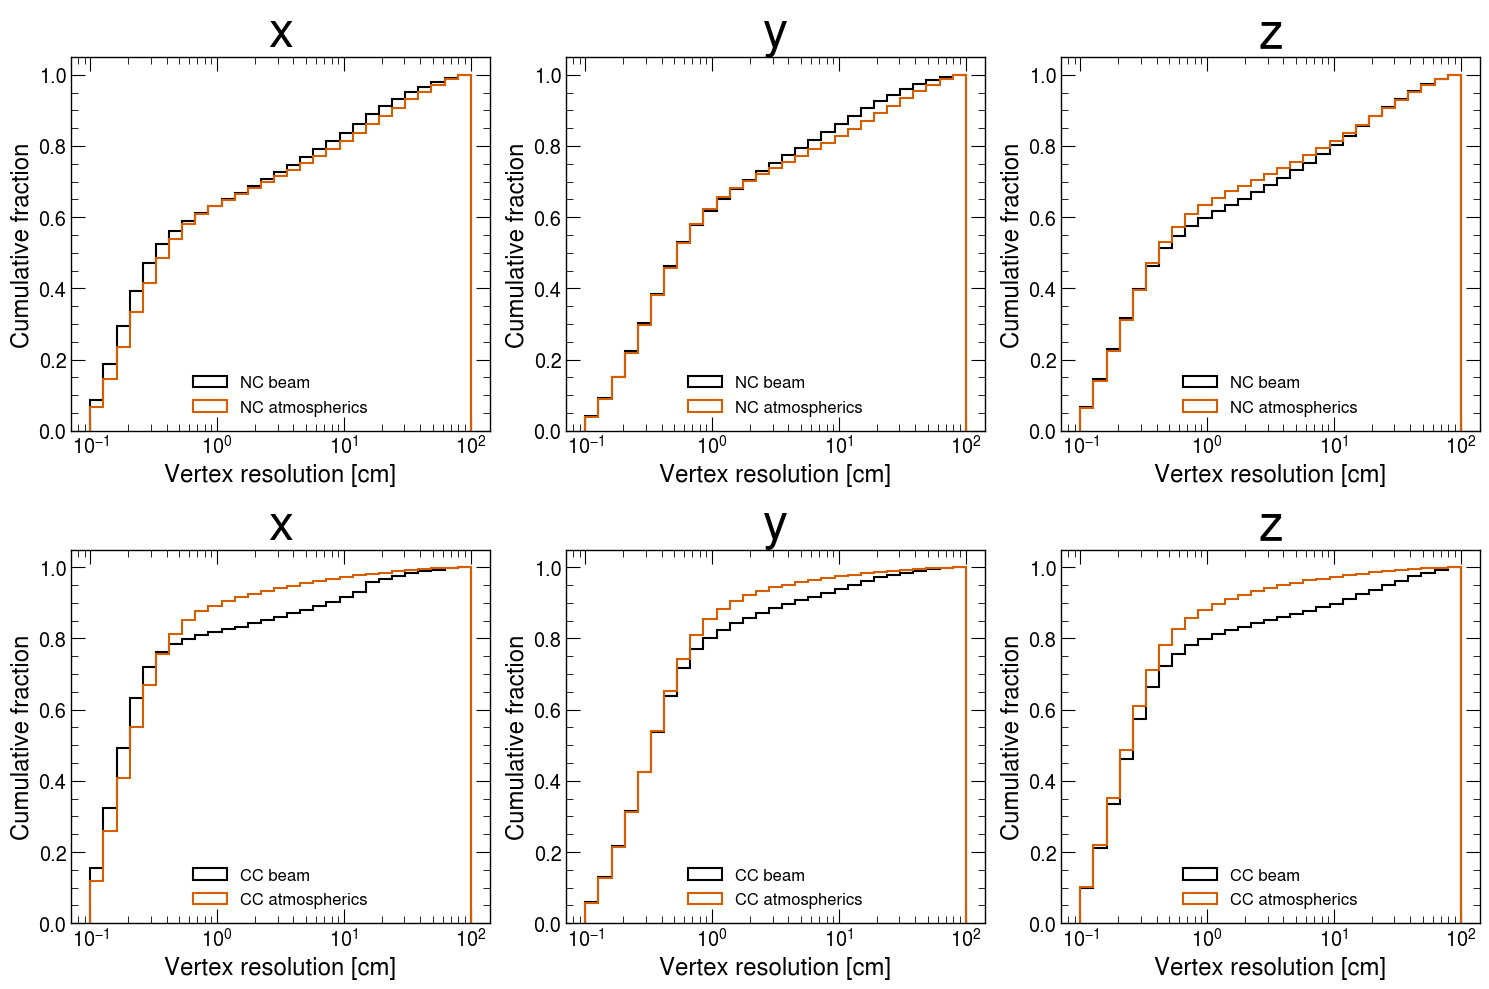

In [12]:
def vertex_plots(data, labels=None, cum=False, filters=[]):
    if not isinstance(data, list):
        data = [data]

    if labels:
        if not isinstance(labels, list):
            labels = [labels]
    else:
        labels = ["" for i in range(len(data))]
    assert(len(labels) == len(data))


    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    bins = np.logspace(-1, 2, 30)

    def filtering(df):
        return df.filter(
            pl.col('RecoVtx_x') != -999,
            *filters
        )

    selected = [filtering(df) for df in data]

    for i, direc in enumerate(['x', 'y', 'z']):
        for iscc in [0, 1]:
            ax = axs[iscc, i]
            ax.set_title(f'{direc}')
            label = "CC" if iscc else "NC"
            for idx, df in enumerate(selected):
                df_inter = df.filter(
                    pl.col('IsCC') == iscc
                )
                ax.hist(np.abs(df_inter[f'TrueVtx_{direc}'] - df_inter[f'RecoVtx_{direc}']), bins=bins, histtype='step', label=f"{label} {labels[idx]}",
                        density=True, cumulative=cum)
                #weights=np.ones(len(df_inter))/len(df_inter)
                
            ax.set_xscale('log')
            ax.set_xlabel("Vertex resolution [cm]")
            # ax.set_ylabel("# entries")
            ax.set_ylabel("Cumulative fraction")
            ax.legend(loc='lower center')
    fig.tight_layout()
    fig.savefig("vtx_res.pdf")

vertex_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    True,
    [pl.col('TrueNuPdg') == 14])

/tmp/ipykernel_221743/4176511229.py:41: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), values, yerr=values/np.sqrt(2*(count - 1)), label=f"{label} {labels[idx]}", marker='o', linestyle='none')
/tmp/ipykernel_221743/4176511229.py:41: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), values, yerr=values/np.sqrt(2*(count - 1)), label=f"{label} {labels[idx]}", marker='o', linestyle='none')
/tmp/ipykernel_221743/4176511229.py:41: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), values, yerr=values/np.sqrt(2*(count - 1)), label=f"{label} {labels[idx]}", marker='o', linestyle='none')
/tmp/ipykernel_221743/4176511229.py:41: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), values, yerr=values/np.sqrt(2*(count - 1)), label=f"{label} {labels[idx]}", marker='o', linestyle='none')
/tmp/ipykernel_221743/4176511229.py:41: 

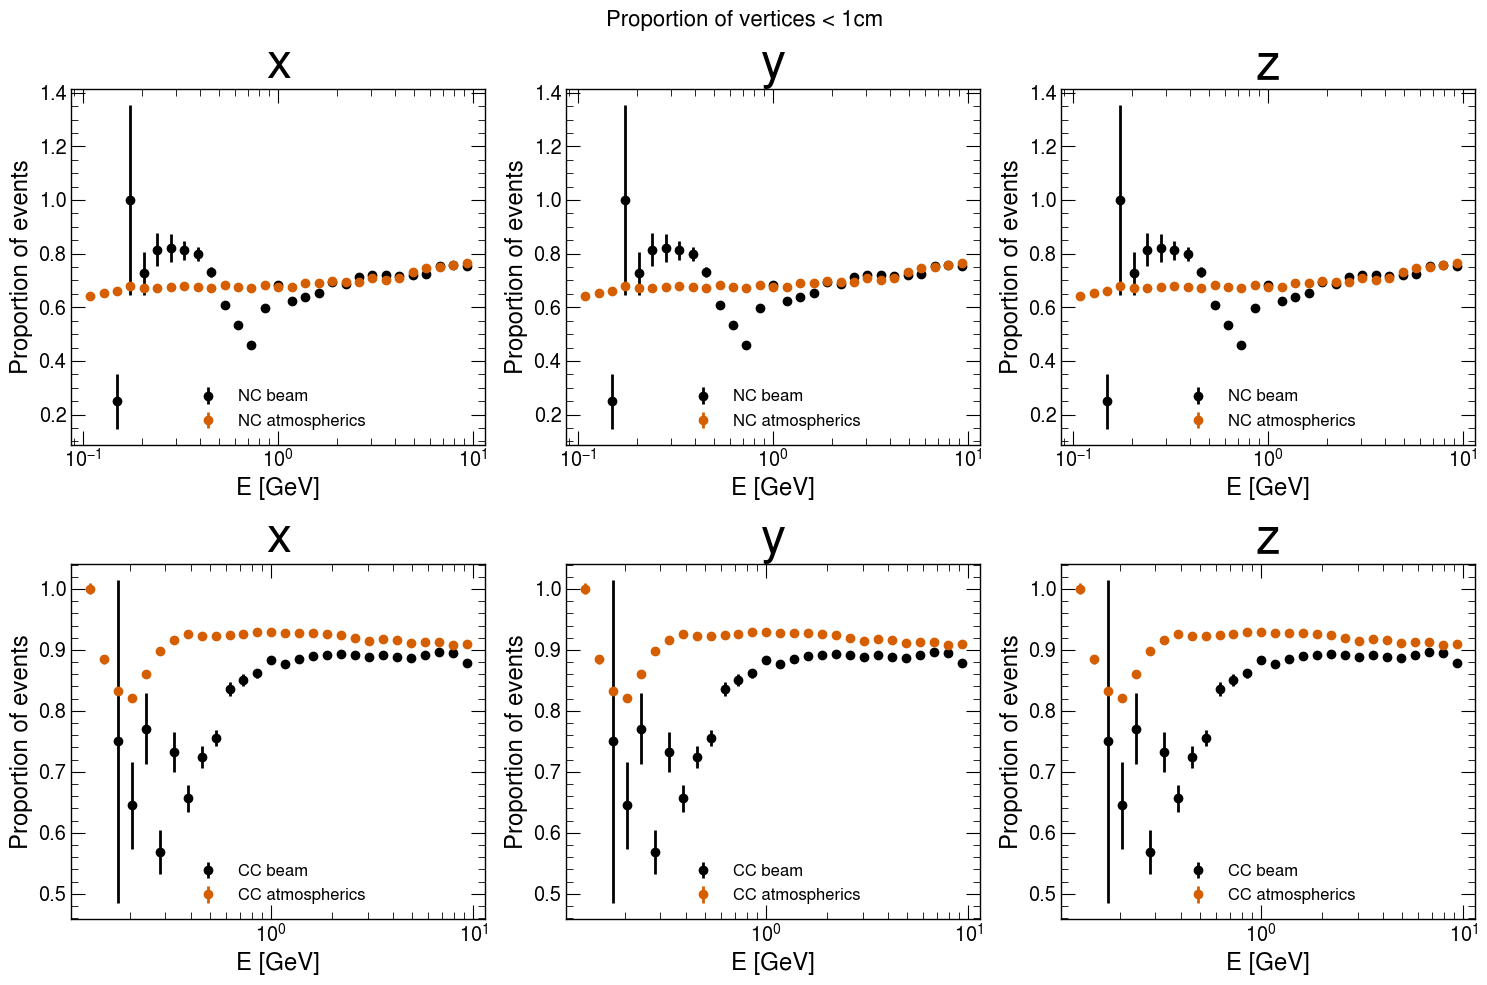

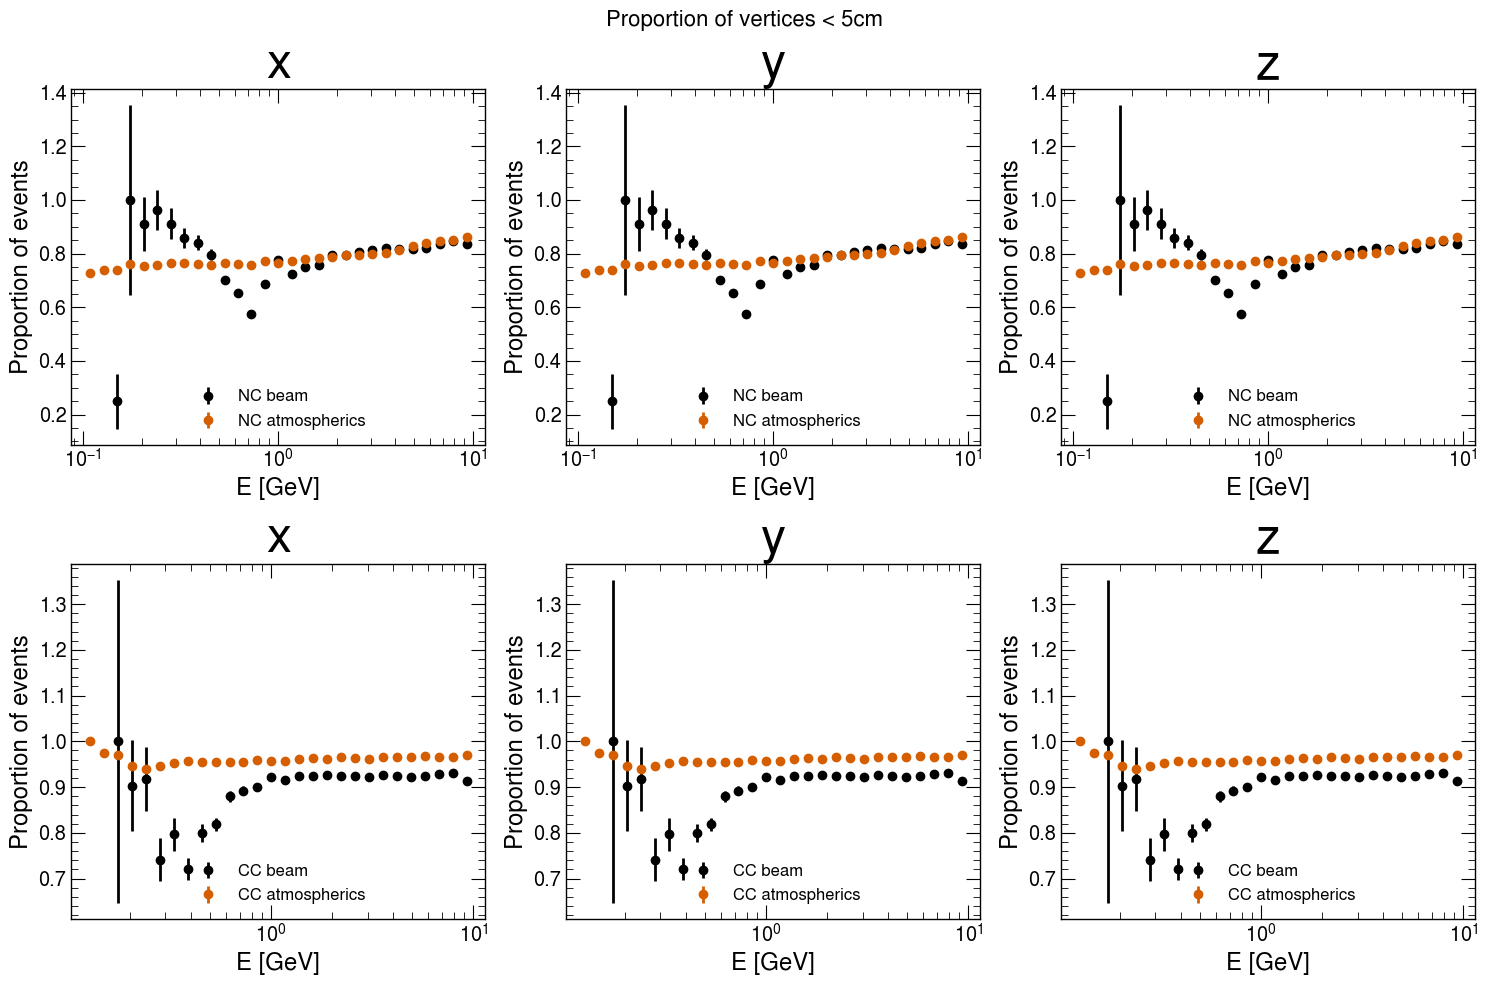

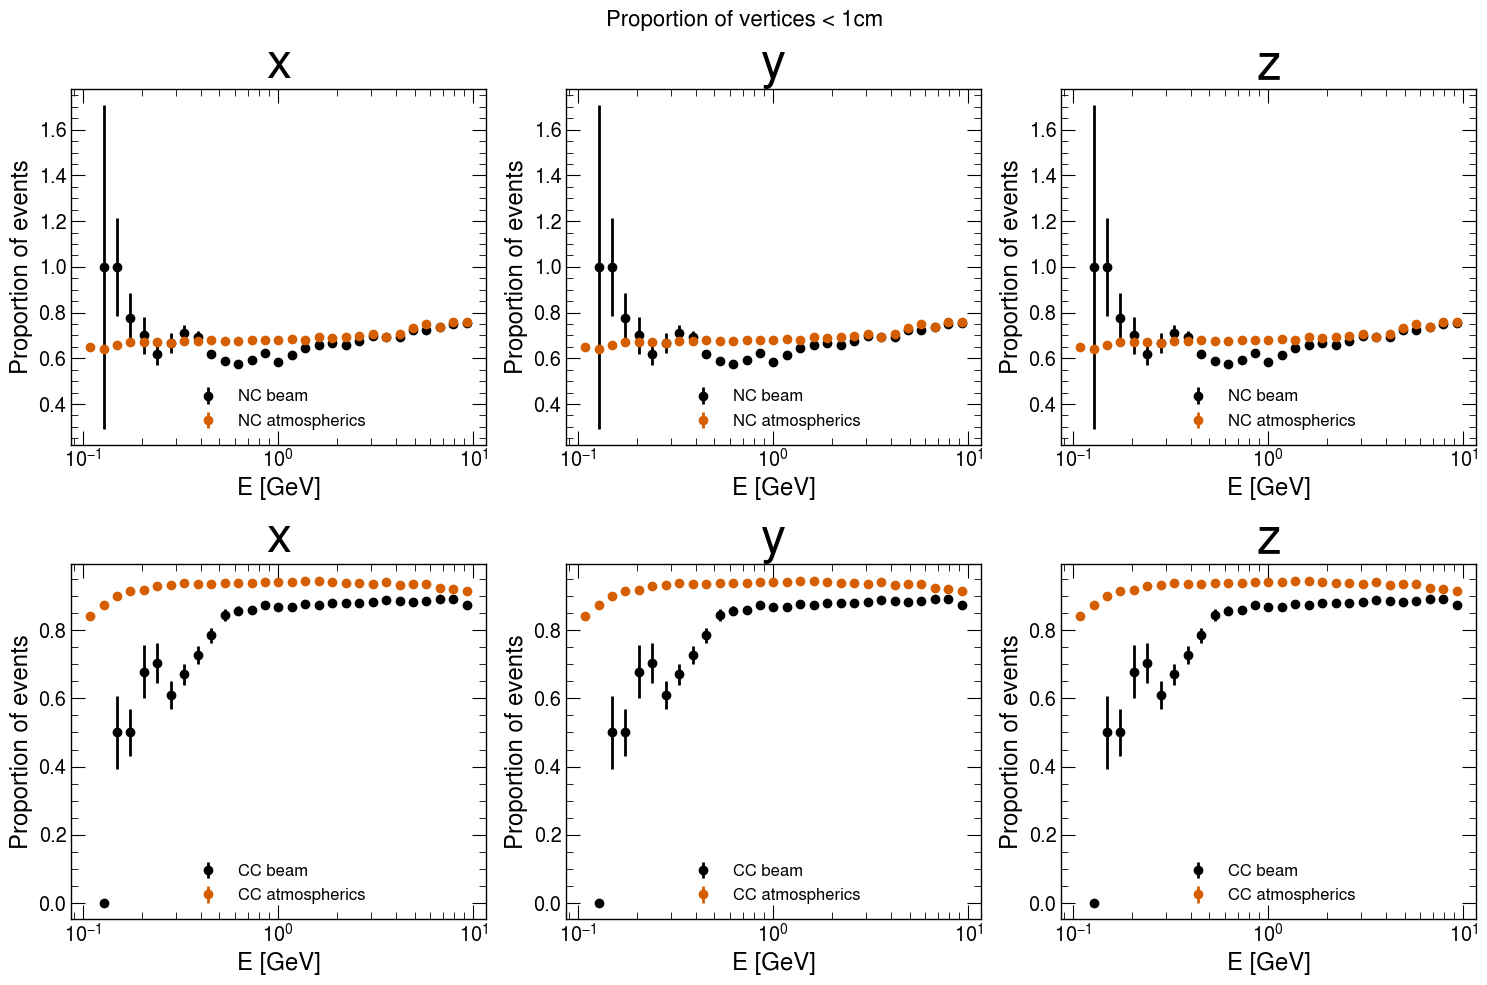

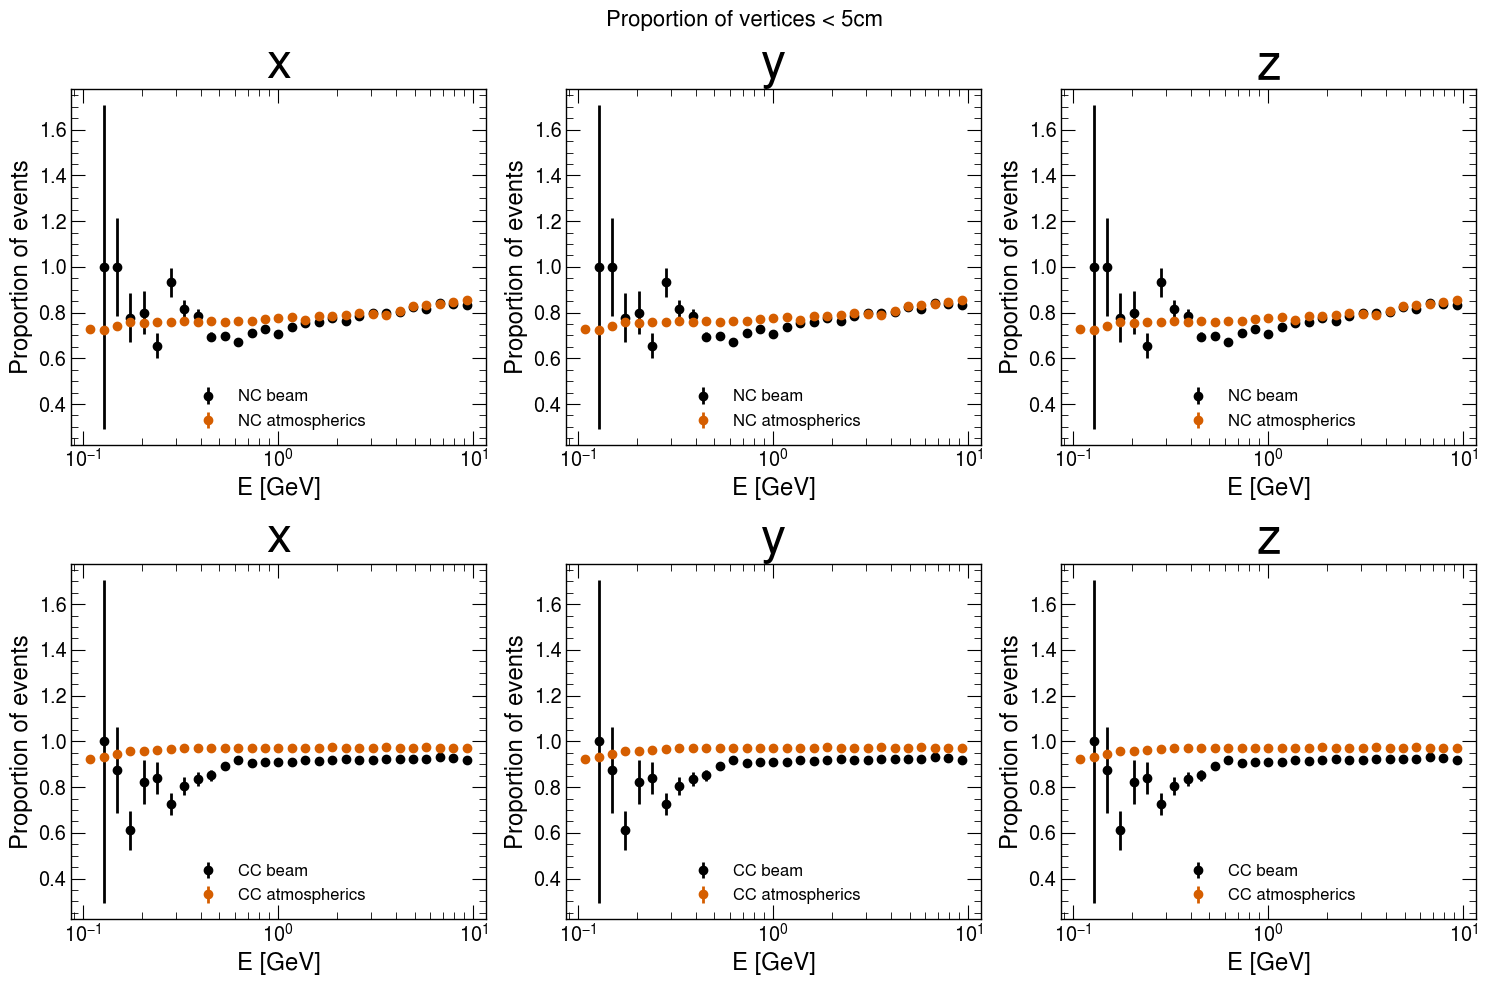

In [29]:
from scipy.stats import binned_statistic

def proportion_below(data, dist):
    return len(data[data < dist])/len(data)

def vertex_plots(data, labels=None, cum=False, filters=[], below=1):
    if not isinstance(data, list):
        data = [data]

    if labels:
        if not isinstance(labels, list):
            labels = [labels]
    else:
        labels = ["" for i in range(len(data))]
    assert(len(labels) == len(data))


    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    bins = np.logspace(-1, 2, 30)

    def filtering(df):
        return df.filter(
            pl.col('RecoVtx_x') != -999,
            *filters
        )

    selected = [filtering(df) for df in data]

    for i, direc in enumerate(['x', 'y', 'z']):
        for iscc in [0, 1]:
            ax = axs[iscc, i]
            ax.set_title(f'{direc}')
            label = "CC" if iscc else "NC"
            for idx, df in enumerate(selected):
                df_inter = df.filter(
                    pl.col('IsCC') == iscc
                )
                Ebins = np.logspace(-1, 1, 30)
                values, _, _ = binned_statistic(df_inter['TrueNuE'], (df_inter['TrueVtx_x'] - df_inter['RecoVtx_x']).abs(), lambda x: proportion_below(x, below), bins=Ebins)
                count, _, _ = binned_statistic(df['TrueNuE'], np.ones_like(df['TrueNuE']), statistic='count', bins=Ebins)
                ax.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), values, yerr=values/np.sqrt(2*(count - 1)), label=f"{label} {labels[idx]}", marker='o', linestyle='none')
                # ax.hist(np.abs(df_inter[f'TrueVtx_{direc}'] - df_inter[f'RecoVtx_{direc}']), bins=bins, histtype='step', label=f"{label} {labels[idx]}",
                #         density=True, cumulative=cum)
                #weights=np.ones(len(df_inter))/len(df_inter)
                
            ax.set_xscale('log')
            ax.set_xlabel("E [GeV]")
            # ax.set_ylabel("# entries")
            ax.set_ylabel("Proportion of events")
            ax.legend(loc='lower center')
    fig.suptitle(f"Proportion of vertices < {below}cm", fontsize=16)
    fig.tight_layout()
    # fig.savefig("vtx_res.pdf")
    return fig

fig = vertex_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    True,
    [pl.col('TrueNuPdg').abs() == 14],
    1
)
fig.savefig("vtx_1cm_numu.pdf")
fig.savefig("vtx_1cm_numu.png", dpi=300)

fig = vertex_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    True,
    [pl.col('TrueNuPdg').abs() == 14],
    5
)
fig.savefig("vtx_5cm_numu.pdf")
fig.savefig("vtx_5cm_numu.png", dpi=300)

fig = vertex_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    True,
    [pl.col('TrueNuPdg').abs() == 12],
    1
)
fig.savefig("vtx_1cm_nue.pdf")
fig.savefig("vtx_1cm_nue.png", dpi=300)

fig = vertex_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    True,
    [pl.col('TrueNuPdg').abs() == 12],
    5
)
fig.savefig("vtx_5cm_nue.pdf")
fig.savefig("vtx_5cm_nue.png", dpi=300)

/tmp/ipykernel_47384/3705202941.py:30: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, np.cumsum(values.T, axis=0)/np.sum(values.T, axis=0), cmap='jet')


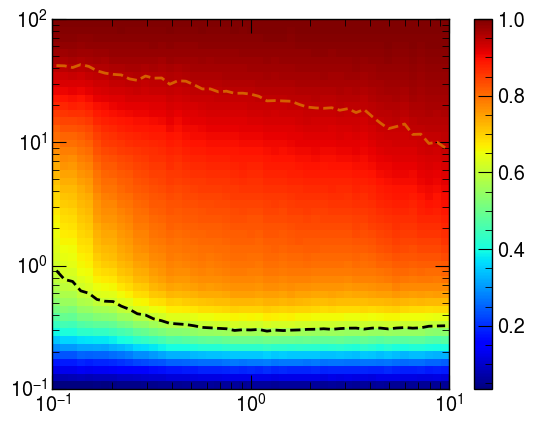

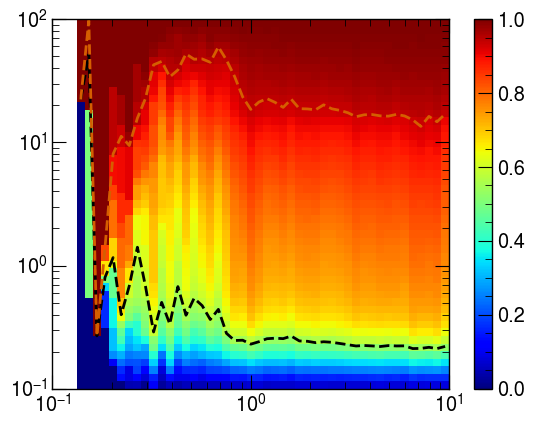

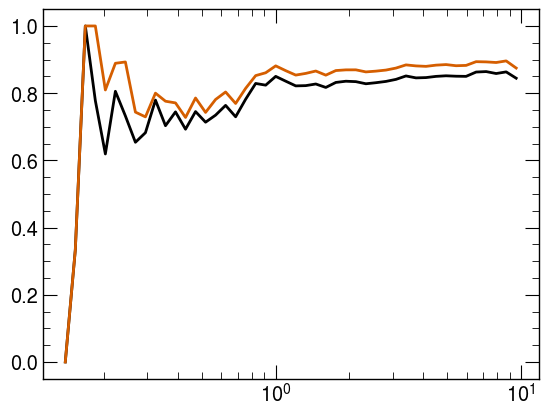

In [114]:
from scipy.stats import binned_statistic

selected = atm_data.filter(
    pl.col('RecoVtx_x') != -999
)
bins = np.logspace(-1, 2, 50)
Ebins = np.logspace(-1, 1, 50)
values, xedges, yedges = np.histogram2d(selected['TrueNuE'], (selected['TrueVtx_x'] - selected['RecoVtx_x']).abs(), bins=(Ebins, bins));
fig = plt.figure()
plt.pcolormesh(xedges, yedges, np.cumsum(values.T, axis=0)/np.sum(values.T, axis=0), cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

def get_contours(data, q, bins):
    inds = np.digitize(data['TrueNuE'], bins)
    res = (data['TrueVtx_x'] - data['RecoVtx_x']).abs().to_numpy()
    return np.array([np.quantile(res[inds == i], q) if len(res[inds == i]) > 0 else [np.nan]*len(q) for i in range(1, len(bins))])

contours = get_contours(selected, [0.68, 0.95], Ebins)

plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), contours[:, 0], linestyle='dashed')
plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), contours[:, 1], linestyle='dashed')

selected = beam_data.filter(
    pl.col('RecoVtx_x') != -999
)
values, xedges, yedges = np.histogram2d(selected['TrueNuE'], (selected['TrueVtx_x'] - selected['RecoVtx_x']).abs(), bins=(Ebins, bins));
fig = plt.figure()
plt.pcolormesh(xedges, yedges, np.cumsum(values.T, axis=0)/np.sum(values.T, axis=0), cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

contours = get_contours(selected, [0.68, 0.95], Ebins)

plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), contours[:, 0], linestyle='dashed')
plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), contours[:, 1], linestyle='dashed')

def proportion_below(data, dist):
    return len(data[data < dist])/len(data)

plt.figure()
values, _, _ = binned_statistic(selected['TrueNuE'], (selected['TrueVtx_x'] - selected['RecoVtx_x']).abs(), lambda x: proportion_below(x, 1), bins=Ebins)
plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), values)
values, _, _ = binned_statistic(selected['TrueNuE'], (selected['TrueVtx_x'] - selected['RecoVtx_x']).abs(), lambda x: proportion_below(x, 3), bins=Ebins)
plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), values)
plt.xscale('log')


/tmp/ipykernel_221743/253811319.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), std_new, yerr=std_new/np.sqrt(2*(count - 1)), label=labels[idx], marker='o', linestyle='none')
/tmp/ipykernel_221743/253811319.py:56: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), std_new, yerr=std_new/np.sqrt(2*(count - 1)), label=labels[idx], marker='o', linestyle='none')
/tmp/ipykernel_221743/253811319.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), std_new, yerr=std_new/np.sqrt(2*(count - 1)), label=labels[idx], marker='o', linestyle='none')
/home/pgranger/.local/lib/python3.10/site-packages/polars/series/series.py:1189: RuntimeWarning: invalid value encountered in arccos
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/tmp/ipykernel_221743/253811319.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.errorba

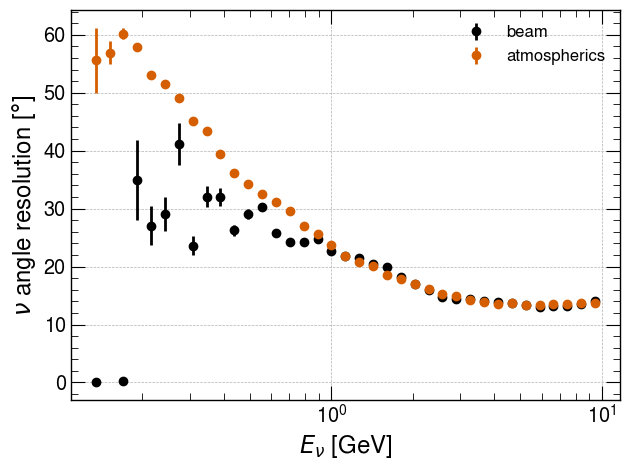

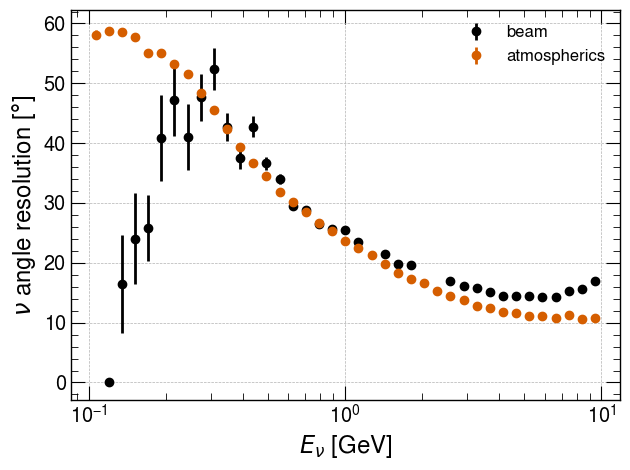

In [82]:
def nu_dcos_truth(dir):
    return pl.col(f'TrueNuP_{dir}')/pl.col('TrueNuE')

def angle():
    return (
        pl.col('nu_dcosx_truth')*pl.col('DirectionRecNuMuPfps_x') +
        pl.col('nu_dcosy_truth')*pl.col('DirectionRecNuMuPfps_y') +
        pl.col('nu_dcosz_truth')*pl.col('DirectionRecNuMuPfps_z')
    ).clip(-1, 1).arccos()

def direction_plots(data, labels, filters=[], method="DirectionRecNuMuPfps"):
    if not isinstance(data, list):
        data = [data]

    if labels:
        if not isinstance(labels, list):
            labels = [labels]
    else:
        labels = ["" for i in range(len(data))]
    assert(len(labels) == len(data))

    def filtering(df):
        return df.with_columns(
            nu_dcosx_truth = pl.col('TrueNuP_x')/pl.col('TrueNuE'),
            nu_dcosy_truth = pl.col('TrueNuP_y')/pl.col('TrueNuE'),
            nu_dcosz_truth = pl.col('TrueNuP_z')/pl.col('TrueNuE'),
        ).filter(
            pl.col("DirectionRecNuMu_y").abs() <= 1,
            pl.col("DirectionRecNuMuPfps_x").abs() <= 1,
            pl.col("DirectionRecNuMuPfps_y").abs() <= 1,
            pl.col("DirectionRecNuMuPfps_z").abs() <= 1,
            pl.col('nu_dcosx_truth').abs() <= 1,
            pl.col('nu_dcosy_truth').abs() <= 1,
            pl.col('nu_dcosz_truth').abs() <= 1,
            *filters
        ).drop_nulls(
        ).with_columns(
            angle = angle()
        )

    selected = [filtering(df) for df in data]

    Ebins = np.logspace(-1, 1, 40)
    # for direc in ['x', 'y', 'z']:
    fig = plt.figure()
    for direc in ['y']:
        # fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

        

        Ebins = np.logspace(-1, 1, 40)
        for idx, df in enumerate(selected):        
            std_new, _, _ = binned_statistic(df['TrueNuE'], (np.arccos(df[f'nu_dcos{direc}_truth']) - np.arccos(df[f'{method}_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
            # std_new, _, _ = binned_statistic(df['TrueNuE'], df['angle']*180/np.pi, statistic=manual_std, bins=Ebins)
            count, _, _ = binned_statistic(df['TrueNuE'], np.ones_like(df['TrueNuE']), statistic='count', bins=Ebins)
            plt.errorbar(0.5*(Ebins[:-1] + Ebins[1:]), std_new, yerr=std_new/np.sqrt(2*(count - 1)), label=labels[idx], marker='o', linestyle='none')

        plt.xscale('log')
        plt.ylabel(r'$\nu$ angle resolution [$\degree$]')
        plt.xlabel(r'$E_\nu$ [GeV]')
        # plt.ylim(7, 63)
        plt.legend()
        # axs[0].set_title(r'$\nu_\mu$ CC')
        plt.grid()
        # dunestyle.TextLabel(text=r'$\nu_\mu$ CC', x=0.05, y=0.05)

    fig.tight_layout()
        # fig1.savefig('numu_angle_reco.pdf')
    return fig

fig = direction_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    [
        pl.col('IsCC') == 1,
        # pl.col("TrueNuPdg") > 0,
        pl.col("TrueNuPdg").abs() == 14
    ])

fig.savefig("direc_numucc.pdf")
fig.savefig("direc_numucc.png", dpi=300)

fig = direction_plots(
    [beam_data, atm_data],
    ["beam", "atmospherics"],
    [
        pl.col('IsCC') == 1,
        # pl.col("TrueNuPdg") > 0,
        pl.col("TrueNuPdg").abs() == 12,
    ],
    "DirectionRecNuEPfps"
    )

fig.savefig("direc_nuecc.pdf")
fig.savefig("direc_nuecc.png", dpi=300)

[ 0.1         0.11253356  0.12663802  0.14251027  0.16037187  0.18047218
  0.20309176  0.22854639  0.25719138  0.28942661  0.32570207  0.36652412
  0.41246264  0.46415888  0.52233451  0.58780161  0.66147406  0.7443803
  0.83767764  0.94266846  1.06081836  1.19377664  1.34339933  1.51177507
  1.70125428  1.91448198  2.15443469  2.42446202  2.72833338  3.07029063
  3.45510729  3.88815518  4.37547938  4.92388263  5.54102033  6.23550734
  7.01703829  7.89652287  8.88623816 10.        ]
[        nan         nan  0.                 nan  0.22378647 34.98034344
 27.06115603 29.11790101 41.11983713 23.62775437 32.06295841 32.03721346
 26.25213884 29.12747612 30.32816778 25.84245151 24.1710638  24.20502099
 24.81958137 22.74696854 21.85473724 21.40396653 20.38228547 19.9436116
 18.20851431 16.95823787 16.00271067 14.68781442 14.35122654 14.41487181
 13.97300283 13.80303499 13.65386388 13.32169116 13.05157258 13.24305007
 13.1922101  13.55578392 14.14407668]
[        nan         nan         nan  

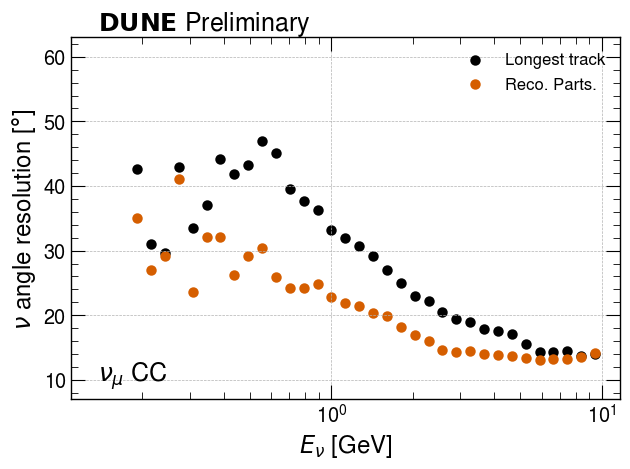

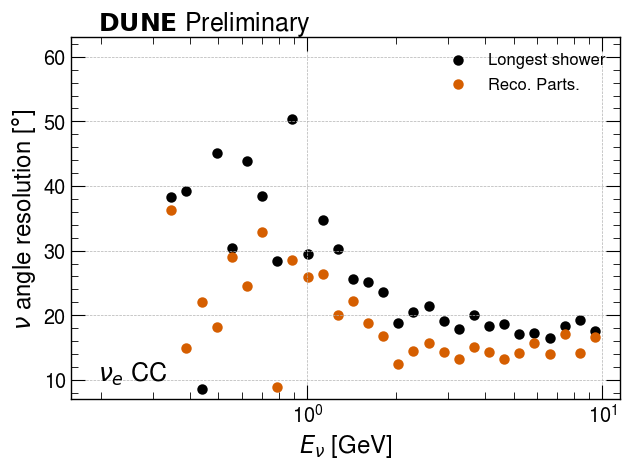

In [158]:
def direction_plots(data):
    data2 = data.with_columns(
        nu_dcosx_truth = pl.col('TrueNuP_x')/pl.col('TrueNuE'),
        nu_dcosy_truth = pl.col('TrueNuP_y')/pl.col('TrueNuE'),
        nu_dcosz_truth = pl.col('TrueNuP_z')/pl.col('TrueNuE'),
    )

    numu_cc = data2.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 14,
        pl.col("DirectionRecNuMu_y").abs() <= 1,
        pl.col("DirectionRecNuMuPfps_y").abs() <= 1,
        pl.col('nu_dcosy_truth').abs() <= 1
        ).drop_nulls()
    nue_cc = data2.filter(
        pl.col('IsCC') == 1,
        pl.col("TrueNuPdg").abs() == 12,
        pl.col("DirectionRecNuE_y").abs() <= 1,
        pl.col("DirectionRecNuEPfps_y").abs() <= 1,
        pl.col('nu_dcosy_truth').abs() <= 1
        ).drop_nulls()
    Ebins = np.logspace(-1, 1, 40)
    # for direc in ['x', 'y', 'z']:
    for direc in ['y']:
        # fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

        fig1 = plt.figure()

        Ebins = np.logspace(-1, 1, 40)
        std, _, _ = binned_statistic(numu_cc['TrueNuE'], (np.arccos(numu_cc[f'nu_dcos{direc}_truth']) - np.arccos(numu_cc[f'DirectionRecNuMu_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Longest track", marker='o')
        
        std_new, _, _ = binned_statistic(numu_cc['TrueNuE'], (np.arccos(numu_cc[f'nu_dcos{direc}_truth']) - np.arccos(numu_cc[f'DirectionRecNuMuPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_new, label="Reco. Parts.", marker='o')
        print(Ebins)
        print(std_new)

        plt.xscale('log')
        plt.ylabel(r'$\nu$ angle resolution [$\degree$]')
        plt.xlabel(r'$E_\nu$ [GeV]')
        plt.ylim(7, 63)
        plt.legend()
        # axs[0].set_title(r'$\nu_\mu$ CC')
        plt.grid()
        dunestyle.Preliminary(y=1.02)
        dunestyle.TextLabel(text=r'$\nu_\mu$ CC', x=0.05, y=0.05)

        fig1.tight_layout()
        # fig1.savefig('numu_angle_reco.pdf')

        fig2 = plt.figure()

        std, _, _ = binned_statistic(nue_cc['TrueNuE'], (np.arccos(nue_cc[f'nu_dcos{direc}_truth']) - np.arccos(nue_cc[f'DirectionRecNuE_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="Longest shower", marker='o')
        

        std_new, _, _ = binned_statistic(nue_cc['TrueNuE'], (np.arccos(nue_cc[f'nu_dcos{direc}_truth']) - np.arccos(nue_cc[f'DirectionRecNuEPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_new, label="Reco. Parts.", marker='o')
        print(std_new)

        plt.xscale('log')
        # axs[1].set_ylabel('Neutrino angle resolution [deg]')
        plt.xlabel(r'$E_\nu$ [GeV]')
        plt.ylabel(r'$\nu$ angle resolution [$\degree$]')
        plt.ylim(7, 63)
        plt.legend()
        # axs[1].set_title(r'$\nu_e$ CC')
        plt.grid()

        dunestyle.Preliminary(y=1.02)
        dunestyle.TextLabel(text=r'$\nu_e$ CC', x=0.05, y=0.05)

        fig2.tight_layout()
        # fig2.savefig("nue_angle_reco.pdf")
direction_plots(beam_data)

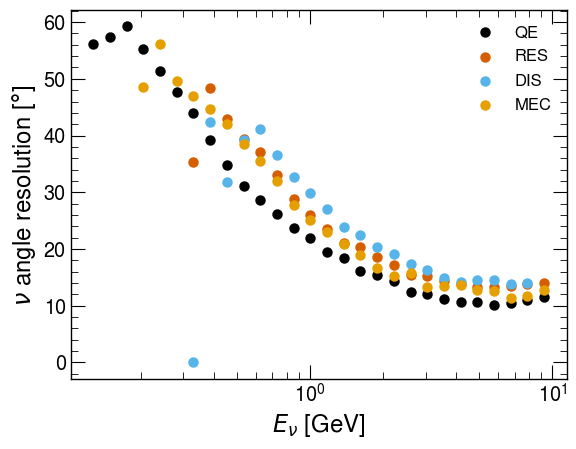

In [87]:
modes = {
    0: "QE",
    1: "RES",
    2: "DIS",
    10: "MEC"
}
Ebins = np.logspace(-1, 1, 30)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig, ax = plt.subplots(1)
axs = [ax]
for mode in modes.keys():
    filtered = atm_data.filter(
        pl.col('InterMode') == mode,
        pl.col('TrueNuPdg').abs() == 14,
        pl.col('IsCC') == 1
    ).with_columns(
        nu_dcosx_truth = pl.col('TrueNuP_x')/pl.col('TrueNuE'),
        nu_dcosy_truth = pl.col('TrueNuP_y')/pl.col('TrueNuE'),
        nu_dcosz_truth = pl.col('TrueNuP_z')/pl.col('TrueNuE'),
    )
    direc = "y"
    avg, _, _ = binned_statistic(filtered['TrueNuE'], (np.arccos(filtered[f'nu_dcos{direc}_truth']) - np.arccos(filtered[f'DirectionRecNuMuPfps_{direc}']))*180/np.pi, statistic='median', bins=Ebins)
    # axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), avg, label=modes[mode])
    std, _, _ = binned_statistic(filtered['TrueNuE'], (np.arccos(filtered[f'nu_dcos{direc}_truth']) - np.arccos(filtered[f'DirectionRecNuMuPfps_{direc}']))*180/np.pi, statistic=manual_std, bins=Ebins)
    axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label=modes[mode])
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel(r"$E_\nu$ [GeV]")
axs[0].set_ylabel(r'$\nu$ angle resolution [$\degree$]')
# axs[1].set_xscale('log')
# axs[1].legend()
# axs[1].set_xlabel(r"$E_\nu$ [GeV]")
# axs[1].set_ylabel(r'Resolution $1 - E_{rec}/E_\nu$')

fig.savefig("dir_modes.png", dpi=300)

In [120]:
# Trying to do the oscillogram with true angle and reco angle, would be quite fun I guess

(<polars.expr.expr.Expr at 0x7ea8caff55a0>,)

In [24]:
beam_data.columns

['eventID',
 'runID',
 'subrunID',
 'TrueVtx_x',
 'TrueVtx_y',
 'TrueVtx_z',
 'TrueNuP_x',
 'TrueNuP_y',
 'TrueNuP_z',
 'TrueNuPdg',
 'TrueNuE',
 'RecoVtx_x',
 'RecoVtx_y',
 'RecoVtx_z',
 'CVNScoreNuMu',
 'CVNScoreNuE',
 'CVNScoreNC',
 'ErecNuMu',
 'ErecNuE',
 'ErecNuMuRange',
 'ErecNuMuMCS',
 'ErecNC',
 'DirectionRecNuE_x',
 'DirectionRecNuE_y',
 'DirectionRecNuE_z',
 'DirectionRecNuMu_x',
 'DirectionRecNuMu_y',
 'DirectionRecNuMu_z',
 'DirectionRecNuEPfps_x',
 'DirectionRecNuEPfps_y',
 'DirectionRecNuEPfps_z',
 'DirectionRecNuMuPfps_x',
 'DirectionRecNuMuPfps_y',
 'DirectionRecNuMuPfps_z',
 'IsCC',
 'InterMode']